Project: Titan Lightcurve - Brightness-phase curve - Deconvolution

Author: Alex Medina

Organization: University of Central Florida

In [2]:
#General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

#Important packages
import vicar
import cv2

#Comparatively to the basic brightness phase curve code, here we do decovnlution
import skimage.restoration

Of course, in creating a brightness phase curve, we only need to calculate two things: brightness(or reflectivity) and phase. Phase is found by reading the metadata which will be involved later in a loop.

For theory, refer to the basic brightness. The key difference here is that instead of using the whole image, we only focus on the disk of Titan. So we calculate the total brightness in the disk of Titan, but with this method, we need to do a deconvolution. I am essentially just doing this to show whether this is more accurate and useful.

Key difference:
- Code to detect and calculate disk of Titan
- line for deconvolution with filter psf

For more on skimage, refer to: https://scikit-image.org/docs/0.25.x/api/skimage.restoration.html 

Here, we input the path where the calibrated images are located. Of course, this is unique to my setup and the data that I have.

In [3]:
if_images = r'C:\Users\Alex\Desktop\Titan\IF Images\CL1_BL2'

#Path to where the .csv file is from
if_metadata = r'C:\Users\Alex\Desktop\Titan\IF Images\CL1_BL2\data.csv'

#Loading the PSF file
psf_file_path = r'C:\Users\Alex\Desktop\Titan\PSF_files\xpsf_nac_cl1_bl2.img'
psf_vic = vicar.VicarImage(psf_file_path, strict=False)
psf_data = psf_vic.data_2d

#Reading the .csv file
parameters_df = pd.read_csv(if_metadata)

In [4]:
#For comparison with default
def reflectivity(image, pixel_scale):
    #R is the radius of Titan for normalization
    R = 2575 #km
    #Total number of pixels
    #n_pixel = np.pi * R**2 / pixel_scale**2
    
    total_if = np.sum(image)

    return (total_if * pixel_scale**2) / (np.pi * R**2)

Here is the circle detection, for more detailed analysis refer to the polarization phase curves.

In [5]:
def image_center(image):

    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    detected_circles = cv2.HoughCircles(gray_image, cv2.HOUGH_GRADIENT, dp=1.2, minDist=100, param1=50, param2=30, minRadius=30, maxRadius=500)

    if detected_circles is not None:
        detected_circles = np.round(detected_circles[0, :]).astype("int")
        for (x, y, r) in detected_circles:
            return (x, y)
    #Debug
    else:
        print("No circle found")
        return None

#To determine the effective radius, as mentioned, I plot the brightness against increasing radius
def radii_fluxes_from_image(image, center):
    x, y = center
    image_copy = image.copy()
    gray_image = cv2.normalize(image_copy, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    radii = range(1, 1000, 5)
    flux = []

    for r in radii:
        mask = np.zeros_like(gray_image)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)
        masked = cv2.bitwise_and(gray_image, gray_image, mask=mask)
        flux.append(np.sum(masked))
    return radii, flux

#Manual inspection and testing
def radii_fluxes_plot(radii, flux):
    plt.plot(radii, flux)
    plt.xlabel("Radius")
    plt.ylabel("Flux")
    plt.title("Flux vs. Radius")
    plt.show()

def effective_radius(radii, flux):
    for i in range(1, len(flux)):
        if flux[i] - flux[i-1] < 0.01 * flux[i-1]:
            return radii[i]
    print("No plateau found")
    return None

In [6]:
def reflectivity_disk(image, center, radius, pixel_scale):
    
    mask = np.zeros_like(image)
    cv2.circle(mask, center, radius, 1, thickness=-1)
    
    total_if = np.sum(image * mask)

    R = 2575  #Titan's radius in km
    #n_pixel = np.pi * R**2 / pixel_scale**2

    return (total_if * pixel_scale**2) / (np.pi * R**2)

For a more detailed comment, refer to basic brightness, but here the only difference are a line for deconvolution and an error line.

In [7]:
images_refl  = []
images_refl_disk = []
phase_angles = []

for filename in os.listdir(if_images):
    if filename.endswith('_CALIB.IMG'):
        
        if_image_path = os.path.join(if_images, filename)
        vic = vicar.VicarImage(if_image_path, strict=False)
        read_if_image = vic.data_2d
        
        #To perform the deconvolution
        deconvolved_image = skimage.restoration.richardson_lucy(read_if_image, psf_data, 30)

        opus_id = filename.split('_')[0]
        opus_id_with_prefix = f'co-iss-{opus_id}'.lower()
        parameter_row = parameters_df[parameters_df['OPUS ID'].str.contains(opus_id_with_prefix)]

        center = image_center(read_if_image)
        #Skip the iteration if no circles are found
        if center is None:
            continue

        radii, fluxes = radii_fluxes_from_image(read_if_image, center)
        optimal_radius = effective_radius(radii, fluxes)

        if not parameter_row.empty:
            #Assocating the meta data with the image, pixel_scale and phase_angle
            phase_angle = parameter_row['Observed Phase Angle (Min) [Titan] (degrees)'].values[0]
            pixel_scale = parameter_row['Body Center Resolution (Min) [Titan] (km/pixel)'].values[0]

            calc_refl = reflectivity(read_if_image, pixel_scale)
            calc_refl_disk = reflectivity_disk(deconvolved_image, center, optimal_radius, pixel_scale)

            #Creating array to plot
            images_refl.append(calc_refl)
            images_refl_disk.append(calc_refl_disk)
            phase_angles.append(phase_angle)

            #For manual inspection
            print(f'{filename}: {calc_refl}, {calc_refl_disk}, {phase_angle}')

N1525327484_1_CALIB.IMG: 0.06221586085381125, 0.062118705927114895, 146.708
N1557905313_1_CALIB.IMG: 0.0986656001367244, 0.09803076453431946, 25.271
N1559282826_1_CALIB.IMG: 0.10457364780577175, 0.10393364756010363, 19.95
N1562037473_1_CALIB.IMG: 0.11132114163473, 0.11067079439734674, 13.467
N1567440211_1_CALIB.IMG: 0.10560363144987396, 0.10428596280855276, 20.043
No circle found
N1571476437_1_CALIB.IMG: 0.050156457949785224, 0.0500845497115047, 79.924
N1578503768_1_CALIB.IMG: 0.07293500366747209, 0.07268988310718824, 47.922
N1617163704_1_CALIB.IMG: 0.03735809841985432, 0.03634333019284875, 105.901
N1617165504_1_CALIB.IMG: 0.03723014271166406, 0.03732614195344521, 105.899
N1644998153_1_CALIB.IMG: 0.0959031064543076, 0.09563540614475093, 27.604
N1645008949_1_CALIB.IMG: 0.09301017396675616, 0.09274398558249355, 30.405
N1645019749_1_CALIB.IMG: 0.09034474939144972, 0.0901045392554912, 32.983
N1646535965_1_CALIB.IMG: 0.08338613240416182, 0.08302597300808638, 42.216
N1671761950_1_CALIB.IMG: 

To see the relative error is we assume that the basic brightness is the correct image (but can work either way).

In [8]:
def difference_q(refl, refl_d):
        #Since dealing witha arrays
        refl = np.asarray(refl)
        relf_d = np.asarray(refl_d)

        #Calculating the difference in the reflectivty value between the whole image and the masked image
        diff = np.abs(refl - refl_d)

        #So the relative difference
        rel_diff = diff / np.abs(refl)

        return rel_diff

refl_errors = difference_q(images_refl, images_refl_disk)

print(f"Mean reflectivity relative error: {np.mean(refl_errors)}")

Mean reflectivity relative error: 0.0057636805168958085


There is a 0.5% mean error, do less thana 1% difference in the images, but deconvolution takes much longer, so it is okay to stick with the basic brightness code. For fun, I will plot the basic in blue and the deconvovled in red to see the difference.

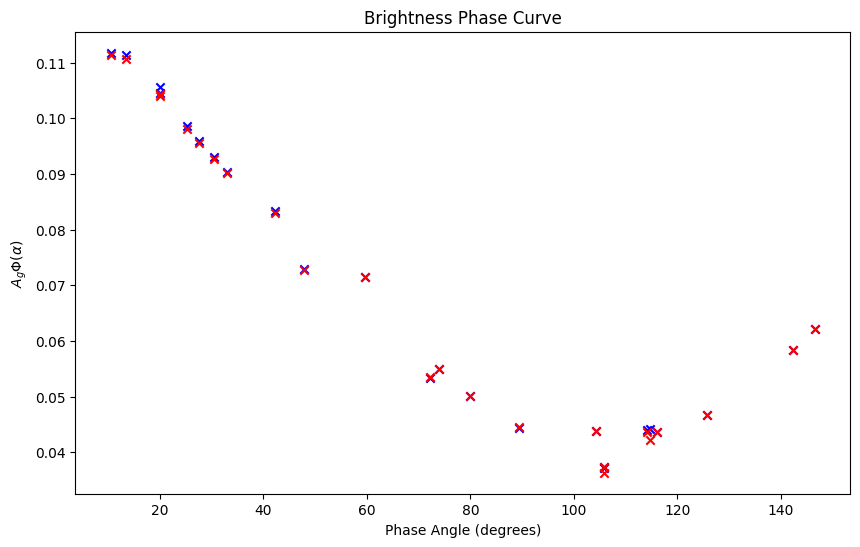

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, images_refl, color='b', marker='x')
plt.scatter(phase_angles, images_refl_disk, color='r', marker='x')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel(r'$A_g \Phi(\alpha)$')
plt.title('Brightness Phase Curve')
plt.show()

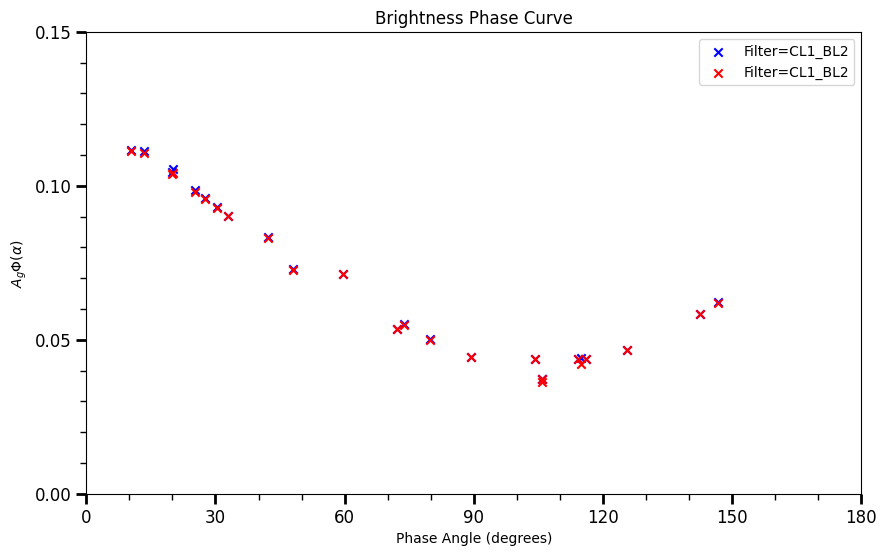

In [10]:
filtername = 'CL1_BL2'

#Same as before
plt.figure(figsize=(10, 6))
plt.scatter(phase_angles, images_refl, color='b', marker='x', label=f'Filter={filtername}')
plt.scatter(phase_angles, images_refl_disk, color='r', marker='x', label=f'Filter={filtername}')
plt.xlabel('Phase Angle (degrees)')
plt.ylabel(r'$A_g \Phi(\alpha)$')
plt.title('Brightness Phase Curve')

#x-ticks(phase angle) at every 10 ticks but a more pronounced tick at every 30 will be more pronounces
ax = plt.gca()
ax.set_xticks(range(0, 181, 30))
ax.set_xticks(range(0, 181, 10), minor=True)
ax.tick_params(axis='x', which='major', length=7, width=2, labelsize=12)
ax.tick_params(axis='x', which='minor', length=4, width=1, labelsize=10)

#Same for the y-axis
#While the x-axis is phase so remains consistent
ay = plt.gca()
#Thicker ticks every 5
ay.set_yticks([i * 0.05 for i in range(4)], minor=False)
ay.set_yticks([i * 0.01 for i in range(15)], minor=True) 
plt.ylim(0, 0.15)

ay.tick_params(axis='y', which='major', length=7, width=2, labelsize=12)
ay.tick_params(axis='y', which='minor', length=4, width=1, labelsize=10)

plt.legend()
plt.show()